In [1]:
import os
import zipfile

ZIP_PATH = "/content/artifacts_xgb_full.zip"
OUT_DIR = "/content/artifacts_xgb"

# 1. Asegurar que existe el directorio destino
os.makedirs(OUT_DIR, exist_ok=True)

# 2. Descomprimir DIRECTAMENTE en OUT_DIR
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(OUT_DIR)  # <--- Aquí forzamos la ruta de destino

print(f"✅ Descompresión finalizada. Todo está guardado en: {OUT_DIR}")

# 3. Verificación (Listar contenido para confirmar)
print("\n📂 Contenido de la carpeta destino:")
!ls -la {OUT_DIR}

✅ Descompresión finalizada. Todo está guardado en: /content/artifacts_xgb

📂 Contenido de la carpeta destino:
total 32
drwxr-xr-x 5 root root 4096 Jan 26 10:07 .
drwxr-xr-x 1 root root 4096 Jan 26 10:39 ..
drwxr-xr-x 2 root root 4096 Jan 26 10:07 models
drwxr-xr-x 2 root root 4096 Jan 26 10:07 plots_xgb
drwxr-xr-x 3 root root 4096 Jan 26 10:23 refined_best
-rw-r--r-- 1 root root  675 Jan 26 10:53 results_xgb_aft_random_cv.csv
-rw-r--r-- 1 root root 5822 Jan 26 10:53 results_xgb_aft_random_cv.parquet


In [2]:
import os, json, glob, re
import xgboost as xgb

ART_DIR = "/content/artifacts_xgb"
REF_DIR = os.path.join(ART_DIR, "refined_best")

meta_files = sorted(glob.glob(os.path.join(REF_DIR, "*_meta.json")))
assert meta_files, f"No encuentro *_meta.json en {REF_DIR}"
meta_path = meta_files[0]

with open(meta_path, "r") as f:
    meta = json.load(f)

print("✅ meta_path:", meta_path)
print("✅ meta keys:", list(meta.keys()))

# --- helpers ---
def resolve_rel(p):
    if p is None:
        return None
    if os.path.isabs(p) and os.path.exists(p):
        return p
    # prueba relativo a refined_best y a artifacts_xgb
    cand1 = os.path.join(REF_DIR, p)
    cand2 = os.path.join(ART_DIR, p)
    if os.path.exists(cand1): return cand1
    if os.path.exists(cand2): return cand2
    return p  # último recurso

# --- 1) intenta encontrar el path en el meta (si existe con otro nombre) ---
model_path = None
for k in ["model_path", "booster_path", "model_file", "booster_file", "path", "xgb_model_path"]:
    if k in meta:
        model_path = resolve_rel(meta[k])
        break

# --- 2) fallback: inferir del nombre del meta ---
if model_path is None:
    model_path = meta_path.replace("_meta.json", ".json")

# validación
assert os.path.exists(model_path), (
    f"No encuentro el modelo en: {model_path}\n"
    f"Archivos en refined_best:\n{os.listdir(REF_DIR)}"
)

# dataset/split (robusto)
best_ds = meta.get("dataset", None)
best_split = meta.get("split", meta.get("scenario", None))

if best_ds is None or best_split is None:
    # fallback por nombre de archivo
    m = re.search(r"_([AB])_(S\d+_[a-z_]+)_meta\.json$", os.path.basename(meta_path))
    if m:
        best_ds, best_split = m.group(1), m.group(2)

print("✅ Mejor refinado:", best_ds, best_split)
print("✅ Model path:", model_path)

booster = xgb.Booster()
booster.load_model(model_path)
print("✅ Booster cargado OK")


✅ meta_path: /content/artifacts_xgb/refined_best/xgb_aft_refined_best_A_S2_strat_event_meta.json
✅ meta keys: ['best_row_from_results_csv', 'dataset', 'split', 'best_nrounds', 'params_used', 'n_train_external', 'n_val_internal', 'note']
✅ Mejor refinado: A S2_strat_event
✅ Model path: /content/artifacts_xgb/refined_best/xgb_aft_refined_best_A_S2_strat_event.json
✅ Booster cargado OK


In [3]:
!pip install scikit-survival


In [4]:
# =========================
# MVP-PLOTS-XGB — Figuras clave (XGB-AFT) usando el MODELO REFINADO
# Requiere: booster cargado + df_expA/df_expB + splits_A/splits_B
# =========================
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import cumulative_dynamic_auc, brier_score, integrated_brier_score


In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

SEED = 42

def build_splits_from_df(df, test_size=0.2, carrera_min=5, seed=SEED):
    idx = np.arange(len(df))

    # S1 random
    tr1, te1 = train_test_split(idx, test_size=test_size, random_state=seed, shuffle=True)
    splits = {"S1_random": (np.sort(tr1), np.sort(te1))}

    # S2 strat by Event
    event = pd.to_numeric(df["Event"], errors="coerce").fillna(0).astype(int).values
    tr2, te2 = train_test_split(idx, test_size=test_size, random_state=seed, shuffle=True, stratify=event)
    splits["S2_strat_event"] = (np.sort(tr2), np.sort(te2))

    # S3 strat by carrera_clean (con colapso de raras)
    if "carrera_clean" not in df.columns:
        print("⚠️ No existe carrera_clean → S3 no se puede.")
        return splits

    car = df["carrera_clean"].astype(str)
    counts = car.value_counts()
    rare = counts[counts < carrera_min].index
    car_s3 = car.where(~car.isin(rare), other=f"OTRAS_<{carrera_min}")

    vc = car_s3.value_counts()
    if (vc < 2).any():
        print("⚠️ S3 NO viable: hay clases con <2 incluso tras agrupar raras.")
    else:
        tr3, te3 = train_test_split(idx, test_size=test_size, random_state=seed, shuffle=True, stratify=car_s3)
        splits["S3_strat_carrera"] = (np.sort(tr3), np.sort(te3))
        print(f"✅ S3 viable: clases={car_s3.nunique()} | OTRAS={(car_s3==f'OTRAS_<{carrera_min}').sum()}")

    # resumen rápido
    def er(ii): return event[ii].mean()
    for k,(tr,te) in splits.items():
        print(f"{k}: train={len(tr)} test={len(te)} | Event rate train={er(tr):.3f} test={er(te):.3f}")

    return splits




In [6]:
import os, json, glob
import numpy as np
import pandas as pd
import xgboost as xgb

# ========= Config =========
ART_DIR = "/content/artifacts_xgb"
REF_DIR = os.path.join(ART_DIR, "refined_best")
PLOT_DIR = os.path.join(REF_DIR, "plots_mvp")
os.makedirs(PLOT_DIR, exist_ok=True)

# ========= 1) Cargar meta del mejor refinado =========
meta_files = sorted(glob.glob(os.path.join(REF_DIR, "*_meta.json")))
assert meta_files, "No encuentro *_meta.json en refined_best."

meta_path = meta_files[0]
with open(meta_path, "r") as f:
    meta = json.load(f)

best_ds = meta["dataset"]      # "A" o "B"
best_split = meta["split"]     # "S2_strat_event" etc
model_json = os.path.join(REF_DIR, f"xgb_aft_refined_best_{best_ds}_{best_split}.json")

print("✅ meta_path:", meta_path)
print("✅ Mejor refinado:", best_ds, best_split)
print("✅ Model json:", model_json)

booster = xgb.Booster()
booster.load_model(model_json)
print("✅ Booster cargado OK")

params_used = meta.get("params_used", {})
aft_dist = params_used.get("aft_loss_distribution", "normal")
aft_scale = float(params_used.get("aft_loss_distribution_scale", 1.0))
print("✅ AFT dist/scale:", aft_dist, aft_scale)

# ========= 2) Cargar datasets limpios =========
df_expA = pd.read_csv("df_expA_cleaned.csv")
df_expB = pd.read_csv("df_expB_cleaned.csv")

df_use = df_expA if best_ds == "A" else df_expB

# ========= 3) Re-crear splits (misma función que ya usaste) =========
from sklearn.model_selection import train_test_split

SEED = 42

def build_splits_from_df(df, test_size=0.2, carrera_min=5, seed=SEED):
    idx = np.arange(len(df))

    # S1 random
    tr1, te1 = train_test_split(idx, test_size=test_size, random_state=seed, shuffle=True)
    splits = {"S1_random": (np.sort(tr1), np.sort(te1))}

    # S2 strat by Event
    event = pd.to_numeric(df["Event"], errors="coerce").fillna(0).astype(int).values
    tr2, te2 = train_test_split(idx, test_size=test_size, random_state=seed, shuffle=True, stratify=event)
    splits["S2_strat_event"] = (np.sort(tr2), np.sort(te2))

    # S3 strat by carrera_clean (colapsando raras)
    if "carrera_clean" in df.columns:
        car = df["carrera_clean"].astype(str)
        counts = car.value_counts()
        rare = counts[counts < carrera_min].index
        car_s3 = car.where(~car.isin(rare), other=f"OTRAS_<{carrera_min}")
        vc = car_s3.value_counts()
        if (vc < 2).any():
            pass
        else:
            tr3, te3 = train_test_split(idx, test_size=test_size, random_state=seed, shuffle=True, stratify=car_s3)
            splits["S3_strat_carrera"] = (np.sort(tr3), np.sort(te3))
    return splits

splits_A = build_splits_from_df(df_expA, test_size=0.2, carrera_min=5)
splits_B = build_splits_from_df(df_expB, test_size=0.2, carrera_min=5)
splits_use = splits_A if best_ds == "A" else splits_B

assert best_split in splits_use, f"Split {best_split} no existe en splits_{best_ds}."

tr_idx, te_idx = splits_use[best_split]
df_tr = df_use.iloc[tr_idx].reset_index(drop=True)
df_te = df_use.iloc[te_idx].reset_index(drop=True)

# ========= 4) Construir X/y (CRÍTICO: drop carrera_clean textual) =========
TARGET_COLS = ["T_Lower","T_Upper","Event"]

# Drop metadata que NO entra a X (según tu decisión)
DROP_FROM_X = ["Cohorte","Genero","Facultad"]

# Drop SIEMPRE texto de carrera_clean / carrera si existen (para evitar el error)
DROP_TEXT_ALWAYS = ["carrera_clean", "carrera"]

drop_cols = [c for c in (TARGET_COLS + DROP_FROM_X + DROP_TEXT_ALWAYS) if c in df_use.columns]

ytr_df = df_tr[TARGET_COLS].copy()
yte_df = df_te[TARGET_COLS].copy()

Xtr = df_tr.drop(columns=drop_cols, errors="ignore").copy()
Xte = df_te.drop(columns=drop_cols, errors="ignore").copy()

# ========= 5) Alinear features EXACTAS del booster =========
def align_to_booster(X: pd.DataFrame, booster: xgb.Booster) -> pd.DataFrame:
    fn = booster.feature_names
    X = X.copy()

    # Si el modelo no tiene nombres, asumimos orden actual (debe coincidir con entrenamiento)
    if fn is None:
        # igual limpiamos cualquier object
        for c in X.select_dtypes(include=["object"]).columns:
            X = X.drop(columns=[c])
        return X

    # Asegurar todas las columnas esperadas
    missing = [c for c in fn if c not in X.columns]
    for c in missing:
        X[c] = 0

    # Quitar extras y reordenar
    X = X[fn]

    # Forzar numérico (por si quedó algo raro)
    for c in X.columns:
        if not pd.api.types.is_numeric_dtype(X[c]):
            X[c] = pd.to_numeric(X[c], errors="coerce")
    X = X.fillna(0)

    return X

Xtr = align_to_booster(Xtr, booster)
Xte = align_to_booster(Xte, booster)

# Sanity final: nada object
bad_tr = Xtr.select_dtypes(include=["object"]).columns.tolist()
bad_te = Xte.select_dtypes(include=["object"]).columns.tolist()
assert not bad_tr and not bad_te, f"Quedaron columnas texto: train={bad_tr}, test={bad_te}"

print("✅ Xtr/Xte listos:", Xtr.shape, Xte.shape)


✅ meta_path: /content/artifacts_xgb/refined_best/xgb_aft_refined_best_A_S2_strat_event_meta.json
✅ Mejor refinado: A S2_strat_event
✅ Model json: /content/artifacts_xgb/refined_best/xgb_aft_refined_best_A_S2_strat_event.json
✅ Booster cargado OK
✅ AFT dist/scale: normal 2.8551127078884506
✅ Xtr/Xte listos: (532, 103) (133, 103)


✅ CELDA MVP-1 — Funciones (sin np.erf) + y_struct + predicciones

In [7]:
import math
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import (
    concordance_index_censored,
    cumulative_dynamic_auc,
    brier_score,
    integrated_brier_score
)

def make_t_mid(y_df):
    lo = y_df["T_Lower"].astype(float).values
    up_raw = y_df["T_Upper"].astype(float).values
    up = np.where(np.isfinite(up_raw), up_raw, np.nan)
    cap = np.nanmax(up) if np.isfinite(np.nanmax(up)) else np.nanmax(lo)
    up_cap = np.where(np.isfinite(up_raw), up_raw, cap)
    return (lo + up_cap) / 2.0

def to_struct_y_from_y_df(y_df):
    t_mid = make_t_mid(y_df)
    e = y_df["Event"].astype(int).values.astype(bool)
    return np.array(list(zip(e, t_mid)), dtype=[("event", "?"), ("time", "<f8")])

# --- AFT survival matrix (sin np.erf) ---
def normal_cdf(z):
    z = np.asarray(z, dtype=float)
    return 0.5 * (1.0 + np.vectorize(math.erf)(z / np.sqrt(2.0)))

def logistic_cdf(z):
    z = np.asarray(z, dtype=float)
    return 1.0 / (1.0 + np.exp(-z))

def aft_survival_matrix(mu, times, dist="normal", scale=1.0, eps=1e-12):
    mu = np.asarray(mu, dtype=float).reshape(-1, 1)
    times = np.asarray(times, dtype=float).reshape(1, -1)
    t = np.maximum(times, eps)
    z = (np.log(t) - mu) / float(scale)

    dist = str(dist).lower()
    if dist in ["normal", "gaussian"]:
        F = normal_cdf(z)
    elif dist in ["logistic"]:
        F = logistic_cdf(z)
    else:
        F = normal_cdf(z)

    S = 1.0 - F
    return np.clip(S, 1e-9, 1.0)

def risk_from_mu(mu):
    # mayor riesgo => evento antes => usamos -mu
    return -np.asarray(mu, dtype=float)

# --- y_struct train/test ---
ytr_s = to_struct_y_from_y_df(ytr_df)
yte_s = to_struct_y_from_y_df(yte_df)

t_min = float(yte_s["time"].min())
t_max = float(yte_s["time"].max())
print("✅ Test follow-up:", t_min, "a", t_max)

# --- preds ---
dm_te = xgb.DMatrix(Xte)
mu_te = booster.predict(dm_te)
risk_te = risk_from_mu(mu_te)

# c-index (sanity)
ci = concordance_index_censored(yte_s["event"], yte_s["time"], risk_te)[0]
print("✅ c-index test (sanity):", float(ci))


✅ Test follow-up: 0.5 a 6.0
✅ c-index test (sanity): 0.6160683760683761


✅ CELDA MVP-2 — (G1) KM observada vs predicha + (G2) empleabilidad acumulada

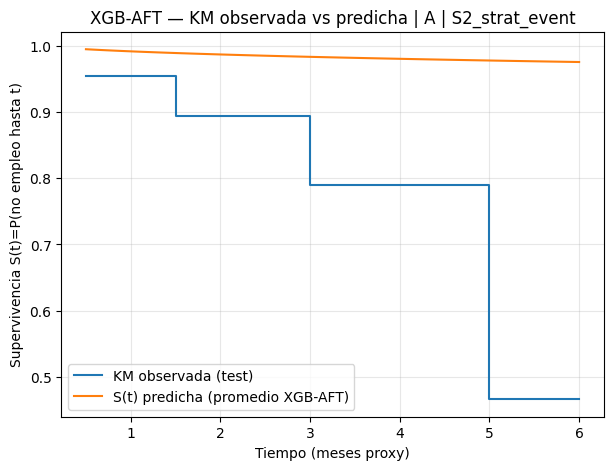

✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/G1_KM_vs_Pred_XGB_A_S2_strat_event.png


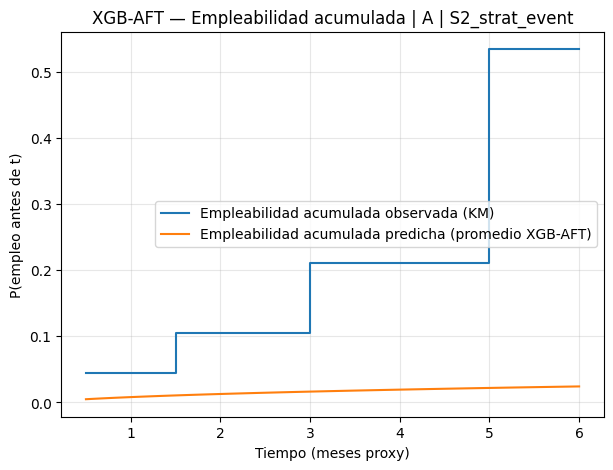

✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/G2_Employability_Cum_XGB_A_S2_strat_event.png


In [9]:
# tiempos SIEMPRE dentro de [t_min, t_max)  (ojo: t_max excluido)
times = np.linspace(t_min, np.nextafter(t_max, t_min), 120)

S_te = aft_survival_matrix(mu_te, times, dist=aft_dist, scale=aft_scale)
S_mean = S_te.mean(axis=0)

# KM observada (test)
t_km, s_km = kaplan_meier_estimator(yte_s["event"], yte_s["time"])

# (G1) S(t)
plt.figure(figsize=(7,5))
plt.step(t_km, s_km, where="post", label="KM observada (test)")
plt.plot(times, S_mean, label="S(t) predicha (promedio XGB-AFT)")
plt.xlabel("Tiempo (meses proxy)")
plt.ylabel("Supervivencia S(t)=P(no empleo hasta t)")
plt.title(f"XGB-AFT — KM observada vs predicha | {best_ds} | {best_split}")
plt.grid(True, alpha=0.3)
plt.legend()
out1 = os.path.join(PLOT_DIR, f"G1_KM_vs_Pred_XGB_{best_ds}_{best_split}.png")
plt.savefig(out1, dpi=160, bbox_inches="tight")
plt.show()
print("✅ Guardada:", out1)

# (G2) 1 - S(t) (empleabilidad acumulada)
plt.figure(figsize=(7,5))
plt.step(t_km, 1.0 - s_km, where="post", label="Empleabilidad acumulada observada (KM)")
plt.plot(times, 1.0 - S_mean, label="Empleabilidad acumulada predicha (promedio XGB-AFT)")
plt.xlabel("Tiempo (meses proxy)")
plt.ylabel("P(empleo antes de t)")
plt.title(f"XGB-AFT — Empleabilidad acumulada | {best_ds} | {best_split}")
plt.grid(True, alpha=0.3)
plt.legend()
out2 = os.path.join(PLOT_DIR, f"G2_Employability_Cum_XGB_{best_ds}_{best_split}.png")
plt.savefig(out2, dpi=160, bbox_inches="tight")
plt.show()
print("✅ Guardada:", out2)


In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb

dm_te = xgb.DMatrix(Xte)

# CLAVE: usar margin (log-time)
mu_te = booster.predict(dm_te, output_margin=True)

print("μ (margin) stats:")
print(pd.Series(mu_te).describe())

print("\nexp(μ) (tiempo “típico” en escala original) stats:")
print(pd.Series(np.exp(mu_te)).describe())


μ (margin) stats:
count    133.000000
mean       2.760764
std        0.725890
min        1.125613
25%        2.350879
50%        2.781907
75%        3.140745
max        4.181207
dtype: float64

exp(μ) (tiempo “típico” en escala original) stats:
count    133.000000
mean      20.362730
std       15.279102
min        3.082106
25%       10.494793
50%       16.149790
75%       23.121092
max       65.444809
dtype: float64


In [13]:
import os, json, glob

# --- Ubicación de artifacts (ajusta si tu carpeta es otra) ---
ART_DIR = "/content/artifacts_xgb"
REF_DIR = os.path.join(ART_DIR, "refined_best")

# Busca el meta del "best refined"
meta_files = sorted(glob.glob(os.path.join(REF_DIR, "*_meta.json")))
assert meta_files, "No encuentro *_meta.json en refined_best"
meta_path = meta_files[0]

with open(meta_path, "r") as f:
    meta = json.load(f)

params_used = meta.get("params_used", meta.get("params", {}))

dist  = params_used.get("aft_loss_distribution", "normal")
scale = float(params_used.get("aft_loss_distribution_scale", 1.0))

print("✅ dist:", dist)
print("✅ scale:", scale)
print("✅ meta:", os.path.basename(meta_path))


✅ dist: normal
✅ scale: 2.8551127078884506
✅ meta: xgb_aft_refined_best_A_S2_strat_event_meta.json


In [14]:
times = np.linspace(t_min, np.nextafter(t_max, t_min), 120)  # siempre < t_max
S_te = aft_survival_matrix(mu_te, times, dist=dist, scale=scale)
S_mean = S_te.mean(axis=0)


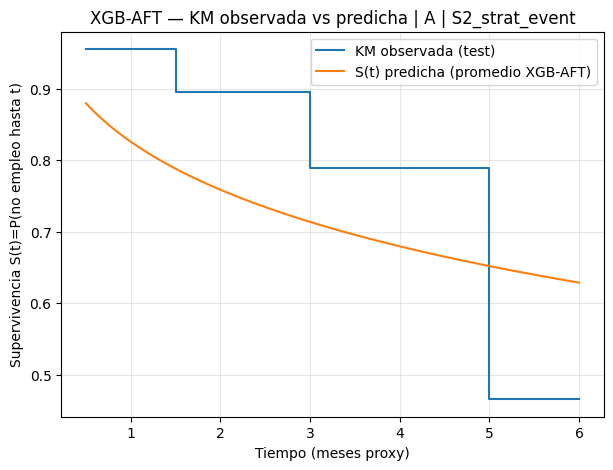

✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/G1_KM_vs_Pred_XGB_A_S2_strat_event.png


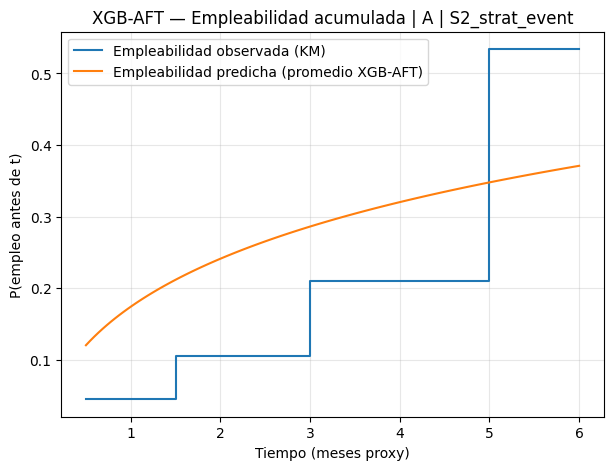

✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/G2_Employability_Cum_XGB_A_S2_strat_event.png
S_mean(t_min)= 0.8795041444898939  | S_mean(t_max-)= 0.6289700156168474
Emp_pred(t_max-)=1-S= 0.3710299843831526


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

# 1) KM observada en test
t_km, s_km = kaplan_meier_estimator(yte_s["event"], yte_s["time"])

# 2) Plot KM vs predicha
plt.figure(figsize=(7,5))
plt.step(t_km, s_km, where="post", label="KM observada (test)")
plt.plot(times, S_mean, label="S(t) predicha (promedio XGB-AFT)")
plt.xlabel("Tiempo (meses proxy)")
plt.ylabel("Supervivencia S(t)=P(no empleo hasta t)")
plt.title(f"XGB-AFT — KM observada vs predicha | {best_ds} | {best_split}")
plt.grid(True, alpha=0.3)
plt.legend()

out1 = os.path.join(PLOT_DIR, f"G1_KM_vs_Pred_XGB_{best_ds}_{best_split}.png")
plt.savefig(out1, dpi=160, bbox_inches="tight")
plt.show()
print("✅ Guardada:", out1)

# 3) Empleabilidad acumulada: 1 - S(t)
plt.figure(figsize=(7,5))
plt.step(t_km, 1.0 - s_km, where="post", label="Empleabilidad observada (KM)")
plt.plot(times, 1.0 - S_mean, label="Empleabilidad predicha (promedio XGB-AFT)")
plt.xlabel("Tiempo (meses proxy)")
plt.ylabel("P(empleo antes de t)")
plt.title(f"XGB-AFT — Empleabilidad acumulada | {best_ds} | {best_split}")
plt.grid(True, alpha=0.3)
plt.legend()

out2 = os.path.join(PLOT_DIR, f"G2_Employability_Cum_XGB_{best_ds}_{best_split}.png")
plt.savefig(out2, dpi=160, bbox_inches="tight")
plt.show()
print("✅ Guardada:", out2)

# 4) Chequeo numérico rápido (para diagnosticar si está pegado arriba)
print("S_mean(t_min)=", float(S_mean[0]), " | S_mean(t_max-)=", float(S_mean[-1]))
print("Emp_pred(t_max-)=1-S=", float(1.0 - S_mean[-1]))


In [16]:
import os, json
meta_path = os.path.join(REF_DIR, f"xgb_aft_refined_best_{best_ds}_{best_split}_meta.json")
meta = json.load(open(meta_path, "r"))

params_used = meta.get("params_used", {})
dist  = params_used.get("aft_loss_distribution", "normal")
scale = float(params_used.get("aft_loss_distribution_scale", 1.0))

print("dist:", dist, "| scale:", scale)


dist: normal | scale: 2.8551127078884506


In [17]:
for col in ["carrera_clean"]:
    if col in Xtr.columns: Xtr = Xtr.drop(columns=[col])
    if col in Xte.columns: Xte = Xte.drop(columns=[col])


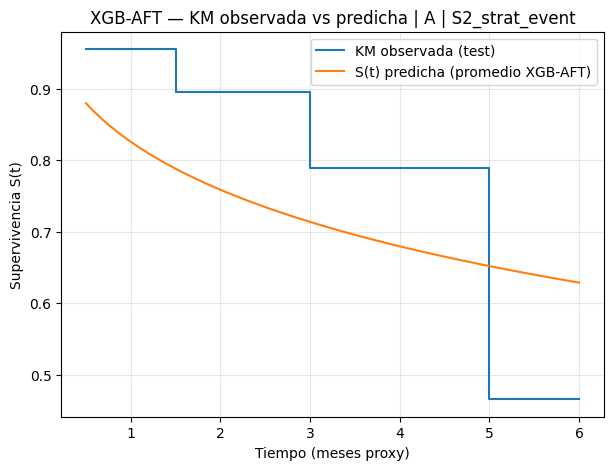

In [18]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

# KM observada en test
t_km, s_km = kaplan_meier_estimator(yte_s["event"], yte_s["time"])

# Predicción AFT (usa margin)
dm_te = xgb.DMatrix(Xte)
mu_te = booster.predict(dm_te, output_margin=True)

times = np.linspace(t_min, np.nextafter(t_max, t_min), 120)  # siempre < t_max
S_te  = aft_survival_matrix(mu_te, times, dist=dist, scale=scale)
S_mean = S_te.mean(axis=0)

plt.figure(figsize=(7,5))
plt.step(t_km, s_km, where="post", label="KM observada (test)")
plt.plot(times, S_mean, label="S(t) predicha (promedio XGB-AFT)")
plt.xlabel("Tiempo (meses proxy)")
plt.ylabel("Supervivencia S(t)")
plt.title(f"XGB-AFT — KM observada vs predicha | {best_ds} | {best_split}")
plt.grid(True, alpha=0.3); plt.legend()
plt.show()


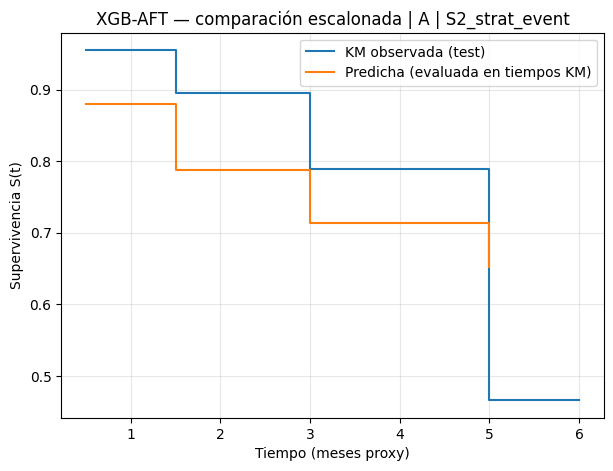

In [19]:
# usa los tiempos de KM dentro del follow-up del test
times_km = t_km[(t_km >= t_min) & (t_km < t_max)]
S_kmgrid = aft_survival_matrix(mu_te, times_km, dist=dist, scale=scale)
S_mean_kmgrid = S_kmgrid.mean(axis=0)

plt.figure(figsize=(7,5))
plt.step(t_km, s_km, where="post", label="KM observada (test)")
plt.step(times_km, S_mean_kmgrid, where="post", label="Predicha (evaluada en tiempos KM)")
plt.xlabel("Tiempo (meses proxy)")
plt.ylabel("Supervivencia S(t)")
plt.title(f"XGB-AFT — comparación escalonada | {best_ds} | {best_split}")
plt.grid(True, alpha=0.3); plt.legend()
plt.show()


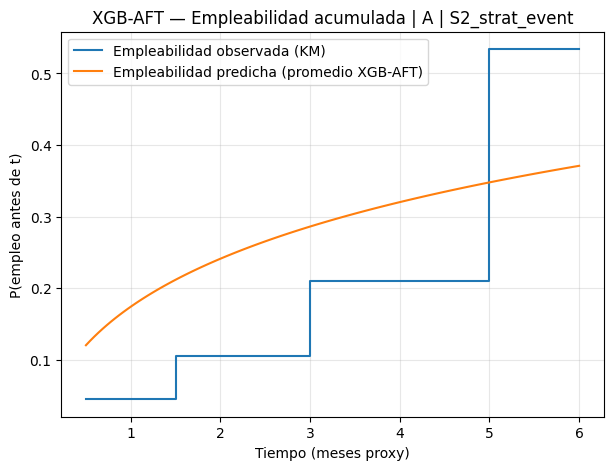

In [20]:
plt.figure(figsize=(7,5))
plt.step(t_km, 1.0 - s_km, where="post", label="Empleabilidad observada (KM)")
plt.plot(times, 1.0 - S_mean, label="Empleabilidad predicha (promedio XGB-AFT)")
plt.xlabel("Tiempo (meses proxy)")
plt.ylabel("P(empleo antes de t)")
plt.title(f"XGB-AFT — Empleabilidad acumulada | {best_ds} | {best_split}")
plt.grid(True, alpha=0.3); plt.legend()
plt.show()


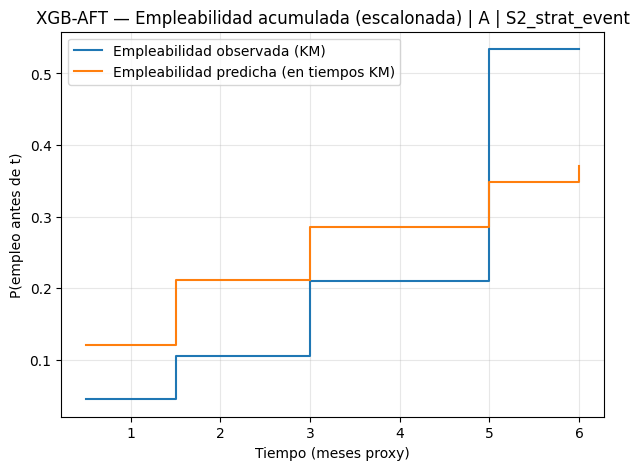

In [21]:
# t_km, s_km ya los tienes (KM observada)
# mu_te ya lo tienes
# dist, scale ya lo tienes

# Predicción evaluada en los mismos tiempos KM:
S_at_km = aft_survival_matrix(mu_te, t_km, dist=dist, scale=scale).mean(axis=0)

plt.figure(figsize=(7,5))
plt.step(t_km, 1.0 - s_km, where="post", label="Empleabilidad observada (KM)")
plt.step(t_km, 1.0 - S_at_km, where="post", label="Empleabilidad predicha (en tiempos KM)")
plt.xlabel("Tiempo (meses proxy)")
plt.ylabel("P(empleo antes de t)")
plt.title(f"XGB-AFT — Empleabilidad acumulada (escalonada) | {best_ds} | {best_split}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


Test follow-up: 0.5 to 6.0


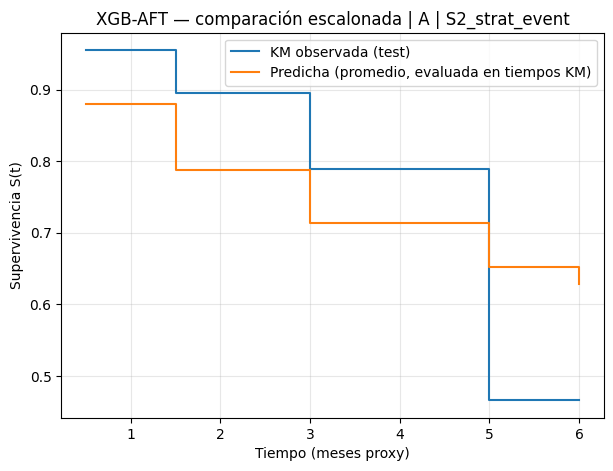

✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/P1_KM_vs_Pred_step_A_S2_strat_event.png


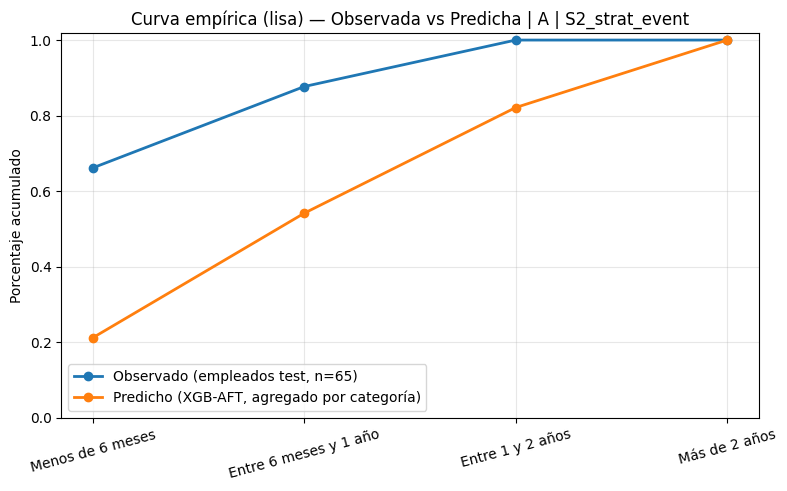

✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/P2_EmpiricalSmoothCats_A_S2_strat_event.png

Obs counts:
 cat
Menos de 6 meses         43
Entre 6 meses y 1 año    14
Entre 1 y 2 años          8
Más de 2 años             0
Name: count, dtype: int64

Pred p por categoría:
 Menos de 6 meses         0.211612
Entre 6 meses y 1 año    0.329800
Entre 1 y 2 años         0.279794
Más de 2 años            0.178793
dtype: float64


In [22]:
import math

# ---------- Helpers (t_mid y y_struct) ----------
def make_t_mid(y_df):
    lo = y_df["T_Lower"].astype(float).values
    up = y_df["T_Upper"].astype(float).replace(np.inf, np.nan).values
    cap = np.nanmax(up) if np.isfinite(np.nanmax(up)) else np.nanmax(lo)
    up_cap = np.where(np.isfinite(y_df["T_Upper"].astype(float).values),
                      y_df["T_Upper"].astype(float).values, cap)
    return (lo + up_cap) / 2.0

def to_struct_y_from_y_df(y_df):
    t_mid = make_t_mid(y_df)
    e = y_df["Event"].astype(int).values.astype(bool)
    return np.array(list(zip(e, t_mid)), dtype=[("event", "?"), ("time", "<f8")])

# ---------- AFT survival matrix (sin np.erf) ----------
def normal_cdf(z):
    z = np.asarray(z, dtype=float)
    return 0.5 * (1.0 + np.vectorize(math.erf)(z / np.sqrt(2.0)))

def logistic_cdf(z):
    z = np.asarray(z, dtype=float)
    return 1.0 / (1.0 + np.exp(-z))

def extreme_cdf(z):
    # Gumbel: F(z)=exp(-exp(-z))
    z = np.asarray(z, dtype=float)
    return np.exp(-np.exp(-z))

def aft_survival_matrix(mu, times, dist="normal", scale=1.0, eps=1e-12):
    mu = np.asarray(mu, dtype=float).reshape(-1, 1)
    times = np.asarray(times, dtype=float).reshape(1, -1)
    t = np.maximum(times, eps)
    z = (np.log(t) - mu) / float(scale)

    d = str(dist).lower()
    if d in ["normal", "gaussian"]:
        F = normal_cdf(z)
    elif d in ["logistic"]:
        F = logistic_cdf(z)
    elif d in ["extreme", "gumbel"]:
        F = extreme_cdf(z)
    else:
        F = normal_cdf(z)

    S = 1.0 - F
    return np.clip(S, 1e-9, 1.0)

# ---------- Build y_struct for test ----------
yte_s = to_struct_y_from_y_df(yte_df)

# ---------- Predict mu correctly ----------
dm_te = xgb.DMatrix(Xte, feature_names=booster.feature_names)
mu_te = booster.predict(dm_te, output_margin=True)  # <- CLAVE
risk_te = -mu_te

t_min = float(yte_s["time"].min())
t_max = float(yte_s["time"].max())
print("Test follow-up:", t_min, "to", t_max)

# =========================================================
# (P1) KM observada vs predicha (escalonada en tiempos KM)
# =========================================================
t_km, s_km = kaplan_meier_estimator(yte_s["event"], yte_s["time"])

S_at_km = aft_survival_matrix(mu_te, t_km, dist=dist, scale=scale).mean(axis=0)

plt.figure(figsize=(7,5))
plt.step(t_km, s_km, where="post", label="KM observada (test)")
plt.step(t_km, S_at_km, where="post", label="Predicha (promedio, evaluada en tiempos KM)")
plt.xlabel("Tiempo (meses proxy)")
plt.ylabel("Supervivencia S(t)")
plt.title(f"XGB-AFT — comparación escalonada | {best_ds} | {best_split}")
plt.grid(True, alpha=0.3)
plt.legend()
out_p1 = os.path.join(PLOT_DIR, f"P1_KM_vs_Pred_step_{best_ds}_{best_split}.png")
plt.savefig(out_p1, dpi=160, bbox_inches="tight")
plt.show()
print("✅ Guardada:", out_p1)

# =========================================================
# (P2) Curva empírica LISA por categorías reales (observada vs predicha)
# =========================================================
# Mapeo proxy -> categoría real (según tu codificación actual)
# 4-6: <6m ; 2-4: 6-12m ; 1-2: 12-24m ; 0-0.1: >24m
CATS = [
    ("Menos de 6 meses", 4.0, 6.0),
    ("Entre 6 meses y 1 año", 2.0, 4.0),
    ("Entre 1 y 2 años", 1.0, 2.0),
    ("Más de 2 años", 0.0, 0.1),
]

def obs_category_from_proxy(lo, up, event):
    if int(event) != 1:
        return None  # curva empírica de "empleados" ignora censurados
    lo = float(lo); up = float(up)
    for name,a,b in CATS:
        if abs(lo-a) < 1e-9 and abs(up-b) < 1e-9:
            return name
    return "OTRA/INCONSISTENTE"

# ----- Observado (solo empleados) -----
tmp = yte_df.copy()
tmp["cat"] = [obs_category_from_proxy(lo, up, e) for lo,up,e in zip(tmp["T_Lower"], tmp["T_Upper"], tmp["Event"])]
tmp_emp = tmp.dropna(subset=["cat"])

obs_counts = tmp_emp["cat"].value_counts().reindex([c[0] for c in CATS]).fillna(0).astype(int)
obs_cum = obs_counts.cumsum() / obs_counts.sum()

# ----- Predicho: probabilidad por bin proxy -----
# p(bin)=S(a)-S(b); normalizamos para que termine en 100% "condicional a empleo"
eps = 1e-6
bounds = []
for _,a,b in CATS:
    a_ = max(a, eps)
    b_ = max(b, eps)
    bounds.extend([a_, b_])
bounds = np.array(sorted(set(bounds)))

S_bounds = aft_survival_matrix(mu_te, bounds, dist=dist, scale=scale)  # (n, m)
S_mean_at = dict(zip(bounds.tolist(), S_bounds.mean(axis=0).tolist()))

pred_p = []
for name,a,b in CATS:
    a_ = max(a, eps); b_ = max(b, eps)
    p = S_mean_at[a_] - S_mean_at[b_]
    pred_p.append(max(p, 0.0))
pred_p = np.array(pred_p, dtype=float)

# normaliza a "solo empleados" (como tu figura empírica)
pred_p = pred_p / pred_p.sum()
pred_cum = np.cumsum(pred_p)

# ----- Plot "liso" por categorías -----
x = np.arange(len(CATS))
labels = [c[0] for c in CATS]

plt.figure(figsize=(9,5))
plt.plot(x, obs_cum.values, marker="o", linewidth=2, label=f"Observado (empleados test, n={obs_counts.sum()})")
plt.plot(x, pred_cum, marker="o", linewidth=2, label="Predicho (XGB-AFT, agregado por categoría)")
plt.xticks(x, labels, rotation=15)
plt.ylim(0, 1.02)
plt.ylabel("Porcentaje acumulado")
plt.title(f"Curva empírica (lisa) — Observada vs Predicha | {best_ds} | {best_split}")
plt.grid(True, alpha=0.3)
plt.legend()
out_p2 = os.path.join(PLOT_DIR, f"P2_EmpiricalSmoothCats_{best_ds}_{best_split}.png")
plt.savefig(out_p2, dpi=160, bbox_inches="tight")
plt.show()
print("✅ Guardada:", out_p2)

print("\nObs counts:\n", obs_counts)
print("\nPred p por categoría:\n", pd.Series(pred_p, index=labels))


### Figura 1 — Validación del modelo: KM observada vs \( \bar S(t) \) predicha
- guardada en ✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/P1_KM_vs_Pred_step_A_S2_strat_event.png


(XGB-AFT, escala *proxy*)

**Qué representa esta figura.**  
La línea azul es la **función de supervivencia observada** estimada con Kaplan–Meier (KM) sobre el conjunto de prueba:
\[
\widehat S_{\text{KM}}(t)\approx P(T>t),
\]
donde “supervivencia” significa **seguir sin empleo hasta el tiempo \(t\)**. Esta curva es **escalonada** porque KM es un estimador no paramétrico que cambia únicamente en tiempos donde se observan eventos.

La línea naranja corresponde a la **supervivencia predicha por el modelo XGB-AFT**, promediada en el conjunto de prueba:
\[
\bar S_{\text{AFT}}(t)=\frac{1}{n}\sum_{i=1}^n S_i(t),
\]
donde \(S_i(t)\) es continua (AFT modela \(\log T\)). Por ello, \(\bar S_{\text{AFT}}(t)\) típicamente se ve **suave**.

**Escala temporal (blindaje).**  
El eje X está en **meses *proxy***, definidos por el **mapeo operativo** del target de censura por intervalos \([T_{\text{lower}},T_{\text{upper}}]\). Por tanto, esta figura valida calibración **en la misma escala usada para entrenar**, no en meses calendario reales.

**Cómo se interpreta la comparación.**  
- Si la curva naranja queda **por encima** de KM en un tramo, el modelo **sobreestima** la probabilidad de “seguir sin empleo” (subestima empleabilidad) en ese tramo.  
- Si queda **por debajo**, el modelo **subestima** \(S(t)\) (predice inserción más rápida que la observada).  
- El objetivo no es que coincidan perfecto (muestra pequeña y target por intervalos), sino verificar si hay **sesgo sistemático** (sub/sobre-estimación persistente) y si la forma general es coherente.

**Mensaje metodológico defendible.**  
Esta figura es una validación visual estándar para supervivencia: contrasta supervivencia **observada** (KM) vs supervivencia **predicha** por el modelo en el mismo horizonte temporal, complementando métricas como C-index e IBS.


### Figura 2 — Curva empírica acumulada (lisa) por rangos declarados: Observada vs Predicha (interpretación)

- guardada en ✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/P2_EmpiricalSmoothCats_A_S2_strat_event.png

**Qué es (y qué NO es).**  
Esta figura **no es Kaplan–Meier**. Es una **curva empírica acumulada por categorías** (bins) definidas por los rangos declarados en la encuesta (p.ej., “<6 meses”, “6–12”, “1–2 años”, “>2 años”). Se construye como una acumulación discreta por categorías:
\[
\widehat F_{\text{emp}}(k)=\frac{\sum_{j\le k} n_j}{\sum_{j} n_j},
\]
donde \(n_j\) es el número de egresados en la categoría \(j\).

**Curva observada (azul).**  
Usualmente se calcula **solo con empleados (E=1)** porque la encuesta reporta rangos de inserción para quienes sí se insertaron. Por tanto, esta curva representa:
\[
P(T \le t \mid E=1),
\]
es decir, la **distribución del tiempo de inserción condicionada a haber conseguido empleo**.

**Curva predicha (naranja).**  
Se obtiene agregando la predicción del modelo por los mismos cortes de categoría. Conceptualmente, el modelo produce \(S(t)\) y por tanto:
\[
P(T\le t)=1-S(t).
\]
Luego se evalúa \(1-\bar S(t)\) en los puntos de corte y se reporta en la misma escala categórica para interpretación.

**Blindaje de comparabilidad (clave para tribunal).**  
- La curva azul (solo \(E=1\)) es **condicional**, mientras que \(1-\bar S(t)\) es **poblacional** (incorpora censura).  
- Por ello, **no se usa como “calibración estricta”**, sino como visualización interpretativa del patrón de inserción por rangos declarados.  
- La validación estadística formal del modelo debe apoyarse en métricas para censura (p.ej., C-index/IBS) y en la figura KM vs \(S(t)\) (Figura 1).

**Cómo presentarla.**  
Titula explícitamente como:
> “Distribución acumulada del tiempo de inserción *condicionada a empleados* (E=1) vs acumulado predicho agregado por categorías”.

Esto evita que se interprete erróneamente como una KM en meses reales.


In [24]:
import os, json
import numpy as np
import pandas as pd
import xgboost as xgb

from sksurv.metrics import (
    concordance_index_censored,
    integrated_brier_score,
    cumulative_dynamic_auc,
    brier_score,
)
from sksurv.nonparametric import kaplan_meier_estimator

# ----------------------------
# Config
# ----------------------------
ART_DIR = "/content/artifacts_xgb"
REF_DIR = os.path.join(ART_DIR, "refined_best")
PLOT_DIR = os.path.join(REF_DIR, "plots_mvp")
os.makedirs(PLOT_DIR, exist_ok=True)

TARGET_COLS = ["T_Lower","T_Upper","Event"]
DROP_FROM_X = ["Cohorte","Genero","Facultad"]  # ajusta si aplica en tu pipeline

# ----------------------------
# Helpers (y_struct + proxy time)
# ----------------------------
def make_t_mid(y_df):
    lo = y_df["T_Lower"].astype(float).values
    up = y_df["T_Upper"].astype(float).replace(np.inf, np.nan).values
    cap = np.nanmax(up) if np.isfinite(np.nanmax(up)) else np.nanmax(lo)
    up_raw = y_df["T_Upper"].astype(float).values
    up_cap = np.where(np.isfinite(up_raw), up_raw, cap)
    return (lo + up_cap) / 2.0

def to_struct_y_from_y_df(y_df):
    t_mid = make_t_mid(y_df)
    e = y_df["Event"].astype(int).values.astype(bool)
    return np.array(list(zip(e, t_mid)), dtype=[("event", "?"), ("time", "<f8")])

# --- AFT survival matrix (sin np.erf) ---
import math
def normal_cdf(z):
    z = np.asarray(z, dtype=float)
    return 0.5 * (1.0 + np.vectorize(math.erf)(z / np.sqrt(2.0)))

def logistic_cdf(z):
    z = np.asarray(z, dtype=float)
    return 1.0 / (1.0 + np.exp(-z))

def aft_survival_matrix(mu, times, dist="normal", scale=1.0, eps=1e-12):
    mu = np.asarray(mu, dtype=float).reshape(-1, 1)       # (n,1)
    times = np.asarray(times, dtype=float).reshape(1, -1) # (1,m)
    t = np.maximum(times, eps)
    z = (np.log(t) - mu) / float(scale)

    dist = str(dist).lower()
    if dist in ["normal", "gaussian"]:
        F = normal_cdf(z)
    elif dist in ["logistic"]:
        F = logistic_cdf(z)
    else:
        F = normal_cdf(z)

    S = 1.0 - F
    return np.clip(S, 1e-9, 1.0)

def risk_from_mu(mu):
    # mayor riesgo = inserción más temprana => -mu
    return -np.asarray(mu, dtype=float)

# ----------------------------
# Cargar datasets limpios
# ----------------------------
df_expA = pd.read_csv("/content/df_expA_cleaned.csv")
df_expB = pd.read_csv("/content/df_expB_cleaned.csv")

df_use = df_expA if best_ds == "A" else df_expB

splits_A = build_splits_from_df(df_expA, test_size=0.2, carrera_min=5)
splits_B = build_splits_from_df(df_expB, test_size=0.2, carrera_min=5)
splits_use = splits_A if best_ds == "A" else splits_B

tr_idx, te_idx = splits_use[best_split]
df_tr = df_use.iloc[tr_idx].reset_index(drop=True)
df_te = df_use.iloc[te_idx].reset_index(drop=True)

# ----------------------------
# Construir X/y (y eliminar texto/categorías crudas)
# ----------------------------
ytr_df = df_tr[TARGET_COLS].copy()
yte_df = df_te[TARGET_COLS].copy()

# si carrera_clean textual existe, se elimina (tu error venía de aquí)
drop_cols = [c for c in (TARGET_COLS + DROP_FROM_X + ["carrera_clean"]) if c in df_use.columns]

Xtr = df_tr.drop(columns=drop_cols, errors="ignore").copy()
Xte = df_te.drop(columns=drop_cols, errors="ignore").copy()

# quedarse solo con numéricas (one-hot y embeddings)
Xtr = Xtr.select_dtypes(include=[np.number, bool]).copy()
Xte = Xte.select_dtypes(include=[np.number, bool]).copy()

# Alinear columnas con el booster (importante para evitar mismatch)
booster_feature_names = booster.feature_names
if booster_feature_names is not None:
    Xtr = Xtr.reindex(columns=booster_feature_names, fill_value=0)
    Xte = Xte.reindex(columns=booster_feature_names, fill_value=0)
else:
    # fallback: asegurar mismo orden
    Xte = Xte.reindex(columns=Xtr.columns, fill_value=0)

# ----------------------------
# y estructurada
# ----------------------------
ytr_s = to_struct_y_from_y_df(ytr_df)
yte_s = to_struct_y_from_y_df(yte_df)

t_min = float(yte_s["time"].min())
t_max = float(yte_s["time"].max())
times = np.linspace(t_min, np.nextafter(t_max, t_min), 120)  # < t_max

# ----------------------------
# Dist/scale desde meta
# ----------------------------
meta_path = os.path.join(REF_DIR, f"xgb_aft_refined_best_{best_ds}_{best_split}_meta.json")
meta = json.load(open(meta_path, "r"))
params_used = meta.get("params_used", {})
dist = params_used.get("aft_loss_distribution", "normal")
scale = float(params_used.get("aft_loss_distribution_scale", 1.0))

print("✅ dist/scale:", dist, scale)

# ----------------------------
# Predicciones
# ----------------------------
dm_te = xgb.DMatrix(Xte, feature_names=list(Xte.columns))
mu_te = booster.predict(dm_te, output_margin=True)   # log-time (μ)
risk_te = risk_from_mu(mu_te)

S_te = aft_survival_matrix(mu_te, times, dist=dist, scale=scale)  # (n_test, n_times)

# ----------------------------
# Métricas
# ----------------------------
cindex = concordance_index_censored(yte_s["event"], yte_s["time"], risk_te)[0]
ibs = integrated_brier_score(ytr_s, yte_s, S_te, times)

# AUC(t) (opcional pero útil)
# Nota: tiempos deben estar dentro del rango del set
times_auc = np.unique(np.clip(np.array([1,2,3,4,5,6], dtype=float), t_min, np.nextafter(t_max, t_min)))
auc_t, mean_auc = cumulative_dynamic_auc(ytr_s, yte_s, risk_te, times_auc)

# Brier por tiempo (para ver dónde calibra mal)
_, bs_t = brier_score(ytr_s, yte_s, S_te, times)

metrics = {
    "dataset": best_ds,
    "split": best_split,
    "n_train": int(len(Xtr)),
    "n_test": int(len(Xte)),
    "cindex_test": float(cindex),
    "ibs_test": float(ibs),
    "mean_auc": float(mean_auc),
}

print("\n=== Métricas (TEST) ===")
for k,v in metrics.items():
    print(f"{k}: {v}")

# Guardar métricas
metrics_path = os.path.join(PLOT_DIR, f"metrics_best_XGB_{best_ds}_{best_split}.json")
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)
print("\n✅ Guardado:", metrics_path)

# Guardar tabla AUC(t) y Brier(t)
df_auc = pd.DataFrame({"t": times_auc, "AUC(t)": auc_t})
df_bs = pd.DataFrame({"t": times, "Brier(t)": bs_t})

auc_path = os.path.join(PLOT_DIR, f"auc_t_best_XGB_{best_ds}_{best_split}.csv")
bs_path  = os.path.join(PLOT_DIR, f"brier_t_best_XGB_{best_ds}_{best_split}.csv")

df_auc.to_csv(auc_path, index=False)
df_bs.to_csv(bs_path, index=False)

print("✅ Guardado:", auc_path)
print("✅ Guardado:", bs_path)


✅ dist/scale: normal 2.8551127078884506

=== Métricas (TEST) ===
dataset: A
split: S2_strat_event
n_train: 532
n_test: 133
cindex_test: 0.6160683760683761
ibs_test: 0.15110661477122922
mean_auc: 0.6404029996755508

✅ Guardado: /content/artifacts_xgb/refined_best/plots_mvp/metrics_best_XGB_A_S2_strat_event.json
✅ Guardado: /content/artifacts_xgb/refined_best/plots_mvp/auc_t_best_XGB_A_S2_strat_event.csv
✅ Guardado: /content/artifacts_xgb/refined_best/plots_mvp/brier_t_best_XGB_A_S2_strat_event.csv


In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) instalar shap si falta
try:
    import shap
except ImportError:
    !pip -q install shap
    import shap

# Reusa Xte ya alineado del bloque anterior (ideal)
# Si no existe Xte en memoria, asegúrate de ejecutar el bloque de métricas primero.

PLOT_DIR = os.path.join("/content/artifacts_xgb", "refined_best", "plots_mvp")
os.makedirs(PLOT_DIR, exist_ok=True)

# 2) Definir features accionables (ajusta nombres si en tu DF son distintos)
skill_cols = [c for c in Xte.columns if c in ["S1","S2","S3","S4","S5","S6","S7"]]
# opcional: edad si existe
if "Edad" in Xte.columns:
    skill_cols.append("Edad")

assert len(skill_cols) > 0, "No encuentro columnas S1..S7 en Xte. Revisa nombres en tu DF."

X_shap = Xte.copy()

# 3) Explainer
# SHAP explica la salida 'raw' del booster (margen): en AFT es μ ≈ log(T)
explainer = shap.TreeExplainer(booster)

# Para acelerar, puedes muestrear (ej. 200 filas)
N_MAX = 300
if len(X_shap) > N_MAX:
    X_shap = X_shap.sample(N_MAX, random_state=42)

shap_values = explainer.shap_values(X_shap)  # (n, n_features)

# 4) Filtrar solo skills para plots principales
idx = [X_shap.columns.get_loc(c) for c in skill_cols]
shap_values_skills = shap_values[:, idx]
X_skills = X_shap[skill_cols]

# 5) Plot BAR (importancia global)
plt.figure()
shap.summary_plot(shap_values_skills, X_skills, plot_type="bar", show=False)
out_bar = os.path.join(PLOT_DIR, f"SHAP_bar_skills_{best_ds}_{best_split}.png")
plt.savefig(out_bar, dpi=170, bbox_inches="tight")
plt.close()
print("✅ Guardada:", out_bar)

# 6) Plot BEESWARM (dirección del efecto)
plt.figure()
shap.summary_plot(shap_values_skills, X_skills, show=False)
out_bee = os.path.join(PLOT_DIR, f"SHAP_beeswarm_skills_{best_ds}_{best_split}.png")
plt.savefig(out_bee, dpi=170, bbox_inches="tight")
plt.close()
print("✅ Guardada:", out_bee)

# 7) Nota interpretativa (para ti):
print("\n📌 Interpretación SHAP en AFT:")
print("- El modelo predice μ ≈ log(T).")
print("- SHAP > 0 => aumenta μ => aumenta el tiempo predicho (inserción más lenta).")
print("- SHAP < 0 => reduce μ => reduce el tiempo predicho (inserción más rápida).")


✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/SHAP_bar_skills_A_S2_strat_event.png
✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/SHAP_beeswarm_skills_A_S2_strat_event.png

📌 Interpretación SHAP en AFT:
- El modelo predice μ ≈ log(T).
- SHAP > 0 => aumenta μ => aumenta el tiempo predicho (inserción más lenta).
- SHAP < 0 => reduce μ => reduce el tiempo predicho (inserción más rápida).


In [26]:
# Ver columnas que "parecen" skills
cands = [c for c in Xte.columns if ("S" in c.upper()) or ("SKILL" in c.upper())]
print("Candidatas tipo skill:", cands[:80])
print("Total candidatas:", len(cands))

# Revisa si existen exactamente S1..S7
print("Exactas S1..S7 presentes:", [c for c in ["S1","S2","S3","S4","S5","S6","S7"] if c in Xte.columns])


Candidatas tipo skill: ['S1_Comunicacion_Esp', 'S2_Compromiso_Etico', 'S3_Trabajo_Equipo_Liderazgo', 'S4_Resp_Social', 'S5_Gestion_Proyectos', 'S6_Aprendizaje_Digital', 'S7_Ingles', 'administración de empresas, gestión de calidad, gestión de datos ...', 'agroindustria, agronomía', 'análisis de datos, análisis de materiales, análisis de sistemas ...', 'aprendizaje no supervisado, aprendizaje supervisado', 'arcgis, qgis', 'arquitectura de computadoras', 'aws, wireless', 'balances de materia y energía', 'base de datos', 'buenas prácticas agrícolas', 'caracterización, clasificación', 'ciberseguridad, seguridad informática', 'control de plagas', 'control de procesos', 'corrosión, regresión', 'costos, costos industriales', 'crm, scrum', 'css, desarrollo web, html ...', 'cálculo estructural, diseño estructural, geología estructural', 'diseño de pcb, diseño de plantas', 'distribución eléctrica, generación eléctrica', 'econometría, modelos econométricos', 'energía renovable, sustentabilidad, tr

In [27]:
import re

def pick_skill_cols(cols):
    pat = re.compile(r"^(S[1-7])($|[_\-])", re.IGNORECASE)  # S1, S1_, S1-...
    out = [c for c in cols if pat.search(str(c))]
    return out

skill_cols = pick_skill_cols(Xte.columns)

# opcional edad
if "Edad" in Xte.columns and "Edad" not in skill_cols:
    skill_cols.append("Edad")

print("✅ skill_cols detectadas:", skill_cols)
assert len(skill_cols) > 1, "Sigue encontrando solo 1 variable. Revisa nombres reales de skills."


✅ skill_cols detectadas: ['S1_Comunicacion_Esp', 'S2_Compromiso_Etico', 'S3_Trabajo_Equipo_Liderazgo', 'S4_Resp_Social', 'S5_Gestion_Proyectos', 'S6_Aprendizaje_Digital', 'S7_Ingles', 'Edad']


In [29]:
fn = booster.feature_names
print("N features en booster:", len(fn) if fn else None)
print("Skills en booster:", [c for c in (fn or []) if str(c).upper().startswith(("S1","S2","S3","S4","S5","S6","S7"))][:50])


N features en booster: 103
Skills en booster: ['S1_Comunicacion_Esp', 'S2_Compromiso_Etico', 'S3_Trabajo_Equipo_Liderazgo', 'S4_Resp_Social', 'S5_Gestion_Proyectos', 'S6_Aprendizaje_Digital', 'S7_Ingles']


In [32]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

# --- SHAP install/import ---
try:
    import shap
except ImportError:
    !pip -q install shap
    import shap

PLOT_DIR = os.path.join("/content/artifacts_xgb", "refined_best", "plots_mvp")
os.makedirs(PLOT_DIR, exist_ok=True)

# --- 1) Alinear Xte EXACTAMENTE a las features del booster ---
feat = booster.feature_names
assert feat is not None and len(feat) > 0, "booster.feature_names vacío."

X_full = Xte.copy()
X_full = X_full.reindex(columns=feat, fill_value=0)

# asegurar numérico puro
for c in X_full.columns:
    if X_full[c].dtype == bool:
        X_full[c] = X_full[c].astype("uint8")
X_full = X_full.apply(pd.to_numeric, errors="coerce").fillna(0)

# muestreo
N_MAX = 300
X_full_s = X_full.sample(min(len(X_full), N_MAX), random_state=42)

print("✅ X_full_s shape (debe ser n x 103):", X_full_s.shape)

# --- 2) SHAP contribs desde XGBoost (IMPORTANTE: SIN output_margin) ---
dm = xgb.DMatrix(X_full_s, feature_names=feat)

# pred_contribs=True => shap por feature + bias al final
contrib = booster.predict(dm, pred_contribs=True)  # <-- FIX: quitar output_margin=True

shap_vals = contrib[:, :-1]   # (n, 103)
base_vals = contrib[:, -1]    # (n,)
print("✅ shap_vals shape:", shap_vals.shape)

# --- 3) Detectar skills tipo S1..S7_ ---
def pick_skill_cols(cols):
    pat = re.compile(r"^(S[1-7])($|[_\-])", re.IGNORECASE)
    return [c for c in cols if pat.search(str(c))]

skill_cols = pick_skill_cols(feat)
if "Edad" in feat and "Edad" not in skill_cols:
    skill_cols.append("Edad")

print("✅ skill_cols:", skill_cols)
assert len(skill_cols) > 0, "No encontré columnas tipo S1..S7_ en el booster."

idx_skills = [feat.index(c) for c in skill_cols]
X_skills = X_full_s[skill_cols]
sv_skills = shap_vals[:, idx_skills]

# --- 4) Plot BAR (skills) ---
plt.figure()
shap.summary_plot(sv_skills, X_skills, plot_type="bar", show=False)
out_bar = os.path.join(PLOT_DIR, f"SHAP_bar_skills_{best_ds}_{best_split}.png")
plt.savefig(out_bar, dpi=170, bbox_inches="tight")
plt.close()
print("✅ Guardada:", out_bar)

# --- 5) Plot BEESWARM (skills) ---
plt.figure()
shap.summary_plot(sv_skills, X_skills, show=False)
out_bee = os.path.join(PLOT_DIR, f"SHAP_beeswarm_skills_{best_ds}_{best_split}.png")
plt.savefig(out_bee, dpi=170, bbox_inches="tight")
plt.close()
print("✅ Guardada:", out_bee)

print("\n📌 Interpretación SHAP en AFT (μ ≈ log(T)):")
print("- SHAP > 0 ⇒ aumenta μ ⇒ aumenta T ⇒ inserción más lenta (más tiempo).")
print("- SHAP < 0 ⇒ reduce μ ⇒ reduce T ⇒ inserción más rápida (menos tiempo).")


✅ X_full_s shape (debe ser n x 103): (133, 103)
✅ shap_vals shape: (133, 103)
✅ skill_cols: ['S1_Comunicacion_Esp', 'S2_Compromiso_Etico', 'S3_Trabajo_Equipo_Liderazgo', 'S4_Resp_Social', 'S5_Gestion_Proyectos', 'S6_Aprendizaje_Digital', 'S7_Ingles', 'Edad']
✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/SHAP_bar_skills_A_S2_strat_event.png
✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/SHAP_beeswarm_skills_A_S2_strat_event.png

📌 Interpretación SHAP en AFT (μ ≈ log(T)):
- SHAP > 0 ⇒ aumenta μ ⇒ aumenta T ⇒ inserción más lenta (más tiempo).
- SHAP < 0 ⇒ reduce μ ⇒ reduce T ⇒ inserción más rápida (menos tiempo).


In [33]:
K = 20
imp = pd.Series(np.mean(np.abs(shap_vals), axis=0), index=feat).sort_values(ascending=False)

# quitar one-hot de carreras
imp_nocarrera = imp[~imp.index.to_series().str.startswith("carrera_clean_")]

top_cols = imp_nocarrera.head(K).index.tolist()
idx_top = [feat.index(c) for c in top_cols]

X_top = X_full_s[top_cols]
sv_top = shap_vals[:, idx_top]

plt.figure()
shap.summary_plot(sv_top, X_top, plot_type="bar", show=False)
out_bar_top = os.path.join(PLOT_DIR, f"SHAP_bar_top{K}_noCarrera_{best_ds}_{best_split}.png")
plt.savefig(out_bar_top, dpi=170, bbox_inches="tight")
plt.close()
print("✅ Guardada:", out_bar_top)

plt.figure()
shap.summary_plot(sv_top, X_top, show=False)
out_bee_top = os.path.join(PLOT_DIR, f"SHAP_beeswarm_top{K}_noCarrera_{best_ds}_{best_split}.png")
plt.savefig(out_bee_top, dpi=170, bbox_inches="tight")
plt.close()
print("✅ Guardada:", out_bee_top)

display(imp_nocarrera.head(K))


✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/SHAP_bar_top20_noCarrera_A_S2_strat_event.png
✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/SHAP_beeswarm_top20_noCarrera_A_S2_strat_event.png


,0
"react, revit",0.160801
"estructura de datos, estructuras",0.152073
"simulación, simulación de procesos",0.125624
"telefonía ip, voz sobre ip",0.073073
S2_Compromiso_Etico,0.056808
"finanzas, mercados financieros",0.052021
S1_Comunicacion_Esp,0.050178
S3_Trabajo_Equipo_Liderazgo,0.043852
Edad,0.043475
S4_Resp_Social,0.040335


,mean_shap (firmado),mean_abs_shap
S1_Comunicacion_Esp,-0.001364,0.050178
S7_Ingles,-0.000931,0.003974
"deep learning, inteligencia artificial, machine learning",-0.000660,0.004940
"agroindustria, agronomía",-0.000356,0.002346
"gis, git",-0.000321,0.001385
"corrosión, regresión",-0.000243,0.010444
"logística, supply chain",-0.000216,0.016369
"cartografía, topografía",-0.000131,0.000359
"energía renovable, sustentabilidad, trazabilidad",-0.000121,0.000402
modelado,-0.000114,0.000254


,mean_shap (firmado),mean_abs_shap
"react, revit",0.038372,0.160801
"estructura de datos, estructuras",0.028930,0.152073
"simulación, simulación de procesos",0.018248,0.125625
S3_Trabajo_Equipo_Liderazgo,0.017173,0.043852
"telefonía ip, voz sobre ip",0.016606,0.073073
S4_Resp_Social,0.010343,0.040335
"finanzas, mercados financieros",0.009239,0.052021
S2_Compromiso_Etico,0.005916,0.056808
"análisis de datos, análisis de materiales, análisis de sistemas ...",0.005916,0.029060
"optimización, optimización de procesos",0.005388,0.034787


✅ Guardado: /content/artifacts_xgb/refined_best/plots_mvp/TOP10_ACCELERA_meanSHAP_A_S2_strat_event.csv
✅ Guardado: /content/artifacts_xgb/refined_best/plots_mvp/TOP10_DESACELERA_meanSHAP_A_S2_strat_event.csv


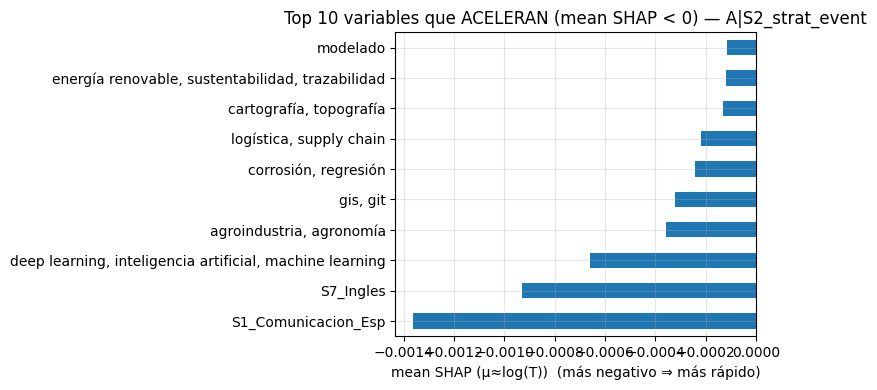

✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/TOP10_ACCELERA_bar_A_S2_strat_event.png


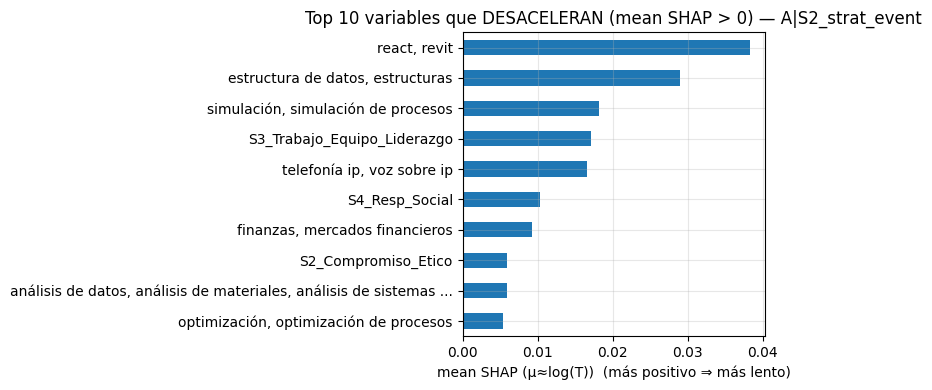

✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/TOP10_DESACELERA_bar_A_S2_strat_event.png


In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PLOT_DIR = os.path.join("/content/artifacts_xgb", "refined_best", "plots_mvp")
os.makedirs(PLOT_DIR, exist_ok=True)

# DataFrame SHAP (mismo orden de columnas que el booster)
shap_df = pd.DataFrame(shap_vals, columns=feat, index=X_full_s.index)

# 1) Excluir carreras (y cualquier otra cosa estructural si quieres)
mask_no_carrera = ~pd.Series(feat).str.startswith("carrera_clean_")
feat_no_carrera = list(pd.Series(feat)[mask_no_carrera])

shap_df_nc = shap_df[feat_no_carrera]

# 2) Ranking por efecto promedio (firmado)
mean_shap = shap_df_nc.mean(axis=0)          # firmado: + desacelera, - acelera
mean_abs  = shap_df_nc.abs().mean(axis=0)    # magnitud promedio

# Top 10 que ACELERAN (más negativos)
top10_acc = mean_shap.sort_values().head(10)

# Top 10 que DESACELERAN (más positivos)
top10_dec = mean_shap.sort_values(ascending=False).head(10)

display(pd.DataFrame({
    "mean_shap (firmado)": top10_acc,
    "mean_abs_shap": mean_abs[top10_acc.index]
}).sort_values("mean_shap (firmado)"))

display(pd.DataFrame({
    "mean_shap (firmado)": top10_dec,
    "mean_abs_shap": mean_abs[top10_dec.index]
}).sort_values("mean_shap (firmado)", ascending=False))

# 3) Guardar CSVs (para tesis/MVP)
out_acc = os.path.join(PLOT_DIR, f"TOP10_ACCELERA_meanSHAP_{best_ds}_{best_split}.csv")
out_dec = os.path.join(PLOT_DIR, f"TOP10_DESACELERA_meanSHAP_{best_ds}_{best_split}.csv")

pd.DataFrame({
    "feature": top10_acc.index,
    "mean_shap": top10_acc.values,
    "mean_abs_shap": mean_abs[top10_acc.index].values
}).to_csv(out_acc, index=False)

pd.DataFrame({
    "feature": top10_dec.index,
    "mean_shap": top10_dec.values,
    "mean_abs_shap": mean_abs[top10_dec.index].values
}).to_csv(out_dec, index=False)

print("✅ Guardado:", out_acc)
print("✅ Guardado:", out_dec)

# 4) Graficar barras (firmadas) — útil para el capítulo de análisis prescriptivo
plt.figure(figsize=(8,4))
top10_acc.sort_values().plot(kind="barh")
plt.title(f"Top 10 variables que ACELERAN (mean SHAP < 0) — {best_ds}|{best_split}")
plt.xlabel("mean SHAP (μ≈log(T))  (más negativo ⇒ más rápido)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
out_fig_acc = os.path.join(PLOT_DIR, f"TOP10_ACCELERA_bar_{best_ds}_{best_split}.png")
plt.savefig(out_fig_acc, dpi=170, bbox_inches="tight")
plt.show()
print("✅ Guardada:", out_fig_acc)

plt.figure(figsize=(8,4))
top10_dec.sort_values().plot(kind="barh")
plt.title(f"Top 10 variables que DESACELERAN (mean SHAP > 0) — {best_ds}|{best_split}")
plt.xlabel("mean SHAP (μ≈log(T))  (más positivo ⇒ más lento)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
out_fig_dec = os.path.join(PLOT_DIR, f"TOP10_DESACELERA_bar_{best_ds}_{best_split}.png")
plt.savefig(out_fig_dec, dpi=170, bbox_inches="tight")
plt.show()
print("✅ Guardada:", out_fig_dec)


## Figura — Top 10 variables que ACELERAN la inserción (mean SHAP < 0)

**Ruta:**  
Guardada: `/content/artifacts_xgb/refined_best/plots_mvp/TOP10_ACCELERA_bar_A_S2_strat_event.png`

### Qué mide esta figura
Para cada variable $j$ se calcula el promedio:
\[
\overline{\phi}_j = \frac{1}{n}\sum_{i=1}^{n}\phi_{ij}
\]
En XGB-AFT:
- si $\overline{\phi}_j < 0$ ⟹ reduce $\mu\approx\log(T)$ ⟹ **reduce el tiempo** predicho ⟹ “acelera”.

### Qué se observa en tu resultado
- Las variables con promedio más negativo están asociadas con **reducción del tiempo esperado** (mayor inserción temprana) **según el modelo**.
- En tu gráfico destacan (en orden aproximado de mayor efecto acelerador):
  - **S1_Comunicacion_Esp** y **S7_Ingles**: soft skills con señal prescriptiva defendible (accionables).
  - Hard skills como **deep learning/AI/ML**, **gis/git**, etc.: reflejan asociación con perfiles de alta demanda.
  
### Blindaje (cómo escribirlo)
- “Estas variables se interpretan como **predictores** asociados a menor $\mu$ (menor $\log(T)$) y por tanto menor tiempo esperado.”
- “No implican causalidad; representan patrones aprendidos del dataset institucional evaluado.”


## Figura — Top 10 variables que DESACELERAN la inserción (mean SHAP > 0)

**Ruta (figura):**  
Guardada: `/content/artifacts_xgb/refined_best/plots_mvp/TOP10_DESACELERA_bar_A_S2_strat_event.png`

**Ruta (tabla soporte):**  
Guardado: `/content/artifacts_xgb/refined_best/plots_mvp/TOP10_DESACELERA_meanSHAP_A_S2_strat_event.csv`

### Qué mide esta figura
Aquí $\overline{\phi}_j>0$ indica:
\[
\overline{\phi}_j > 0 \Rightarrow \mu \uparrow \Rightarrow \log(T)\uparrow \Rightarrow T \uparrow
\]
Es decir: contribuyen, en promedio, a un **tiempo esperado mayor** (inserción más lenta) según el modelo.

### Cómo interpretarlo sin caer en “conclusiones peligrosas”
- No se debe afirmar “tener X causa más demora”.  
- En variables binarias, una media positiva puede estar dominada por el patrón “ausencia = lento” o “presencia = lento”.  
  **Por eso se complementa con el beeswarm**, que muestra si los puntos rojos (alto/presente) se van a la derecha o si son los azules (bajo/ausente).

### Lectura sustantiva en tu caso
- Aparecen variables técnicas específicas (p.ej., “react, revit”, “estructura de datos…”, “simulación…”) y soft skills como **S3** y **S4** con promedio positivo.  
- Esto suele indicar **segmentación/heterogeneidad**: esas variables pueden estar actuando como proxies de subgrupos con distintas trayectorias laborales, no como “causas” directas.

### Blindaje recomendado
- “Estas variables presentan contribuciones positivas promedio en $\mu\approx\log(T)$ en el conjunto test, por lo que el modelo las asocia con mayor tiempo esperado. La interpretación es descriptiva y depende de la composición muestral y codificación.”


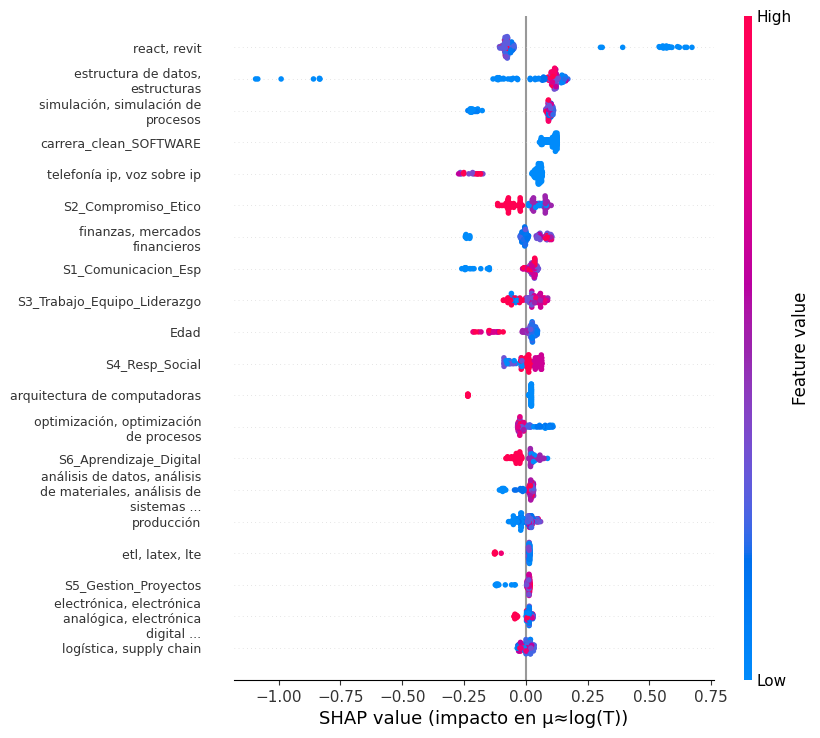

✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/SHAP_beeswarm_Top20_layoutfix_A_S2_strat_event.png


In [35]:
import os, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# =========================
# CONFIG
# =========================
TOP_N = 20          # pon 20 o 30 si quieres
WRAP_CHARS = 28     # ancho para envolver texto (ajusta a 24-35)
USE_WRAP = True     # True = wrap; False = truncar

def wrap_label(s, width=28):
    return "\n".join(textwrap.wrap(str(s), width=width)) if s is not None else ""

def trunc_label(s, max_len=40):
    s = str(s)
    return s if len(s) <= max_len else (s[:max_len-1] + "…")

# =========================
# 1) Selección Top N por mean(|SHAP|)
# =========================
mean_abs = np.abs(shap_vals).mean(axis=0)   # (p,)
top_idx = np.argsort(mean_abs)[::-1][:TOP_N]

X_top = X_full_s.iloc[:, top_idx].copy()
sv_top = shap_vals[:, top_idx]

# Renombrar columnas SOLO para el gráfico (no afecta el modelo)
if USE_WRAP:
    X_top.columns = [wrap_label(c, WRAP_CHARS) for c in X_top.columns]
else:
    X_top.columns = [trunc_label(c, 45) for c in X_top.columns]

# =========================
# 2) Beeswarm "tipo calor" con layout corregido
# =========================
# shap.summary_plot crea su propia figura; plot_size ayuda mucho
shap.summary_plot(
    sv_top, X_top,
    show=False,
    max_display=TOP_N,
    plot_size=(12, 8)  # <- ancho/alto
)

# Ajustes finos de márgenes y tipografía
plt.gcf().subplots_adjust(left=0.48, right=0.98, top=0.95, bottom=0.12)
plt.yticks(fontsize=9)
plt.xlabel("SHAP value (impacto en μ≈log(T))")

out = os.path.join(PLOT_DIR, f"SHAP_beeswarm_Top{TOP_N}_layoutfix_{best_ds}_{best_split}.png")
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.show()
print("✅ Guardada:", out)


## Métricas del mejor modelo XGB-AFT (evaluación en *test externo*)

**Configuración del modelo AFT**
- **Distribución AFT:** `normal`
- **Escala:** `2.8551`

En XGBoost-AFT, el modelo aprende una salida **en escala logarítmica del tiempo**, típicamente:

\[
\mu(x)\approx \log(T)
\]

y, bajo la distribución AFT asumida (normal/logistic), genera una función de supervivencia continua por individuo:

\[
S_i(t)=P(T>t\mid x_i)=1-F\left(\frac{\log(t)-\mu(x_i)}{\text{scale}}\right)
\]

donde \(F(\cdot)\) es la CDF de la distribución (aquí, **Normal**).

---

### Partición evaluada (escenario ganador)
- **dataset:** A  
- **split:** `S2_strat_event` (estratificado por evento)  
- **n\_train:** 532  
- **n\_test:** 133  

Este split es el más “limpio” metodológicamente porque mantiene proporciones similares de evento entre train/test, reduciendo sesgos por desbalance accidental.

---

### Métricas en test (generalización)
#### 1) Concordance Index (C-index)
- **cindex\_test:** **0.6161**

Interpretación:
- El C-index mide **capacidad de ordenamiento** (discriminación): qué tan bien el modelo asigna **mayor riesgo** a quienes se insertan antes.
- \(\approx 0.5\) ≈ azar; \(\approx 1\) ≈ perfecto.
- Un **0.616** indica **señal predictiva moderada**, razonable para datos pequeños y con censura.

> Importante: C-index **no valida calibración** (probabilidades), solo ranking.

---

#### 2) Integrated Brier Score (IBS)
- **ibs\_test:** **0.1511** (↓ mejor)

Interpretación:
- El Brier Score mide error cuadrático entre probabilidad predicha y resultado observado a lo largo del tiempo.
- El **IBS** integra ese error en el rango temporal evaluado.
- Valores más bajos indican **mejor calibración y precisión probabilística** global.

---

#### 3) AUC dependiente del tiempo (promedio)
- **mean\_auc:** **0.6404**

Interpretación:
- Resume desempeño de discriminación en múltiples puntos temporales \((t)\).
- Similar a C-index en “espíritu”, pero evaluado por *tiempos*.
- **0.64** refuerza la idea de **discriminación moderada**.

---

### Archivos guardados (evidencia reproducible)
- `metrics_best_XGB_A_S2_strat_event.json`: resumen de métricas y configuración
- `auc_t_best_XGB_A_S2_strat_event.csv`: AUC(t) por tiempo
- `brier_t_best_XGB_A_S2_strat_event.csv`: Brier(t) por tiempo

Estos artefactos sirven como **trazabilidad** para tu tesis y el MVP.


## Interpretación de SHAP (Beeswarm) — Top 20 variables

### Qué está explicando SHAP en XGB-AFT
En XGB-AFT, el modelo predice un valor:

\[
\mu(x)\approx \log(T)
\quad\Rightarrow\quad
T_{\text{típico}} \approx \exp(\mu)
\]

Por tanto, el signo de SHAP se interpreta así:

- **SHAP > 0**  \(\Rightarrow\) aumenta \(\mu\) \(\Rightarrow\) aumenta \(\log(T)\) \(\Rightarrow\) **tiempo predicho mayor**  
  **(inserción más lenta / DESACELERA)**

- **SHAP < 0**  \(\Rightarrow\) reduce \(\mu\) \(\Rightarrow\) reduce \(\log(T)\) \(\Rightarrow\) **tiempo predicho menor**  
  **(inserción más rápida / ACELERA)**

---

### Cómo leer la gráfica Beeswarm
- **Eje Y:** variables ordenadas por importancia global (≈ media de \(|\text{SHAP}|\)).  
  Arriba = más influyentes en el modelo.
- **Eje X:** valor SHAP (impacto sobre \(\mu \approx \log(T)\)).
  - Izquierda (negativo) = acelera inserción.
  - Derecha (positivo) = desacelera inserción.
- **Cada punto:** una persona (una fila del test).
- **Color:** valor de la variable
  - **Rojo = valor alto**
  - **Azul = valor bajo**
  Para one-hot (0/1), rojo suele ser “presente = 1”, azul “ausente = 0”.

---

### Regla práctica para extraer conclusiones
Para cada variable:
- Si los puntos **rojos** aparecen mayormente **a la izquierda**, entonces **valores altos** de esa variable tienden a **ACELERAR** la inserción.
- Si los puntos **rojos** aparecen mayormente **a la derecha**, entonces valores altos tienden a **DESACELERAR** la inserción.
- Si hay mezcla fuerte (rojo/azul a ambos lados), la relación puede ser **no lineal** o depender de interacciones.

---

### Blindaje metodológico (muy importante)
- SHAP explica asociaciones del modelo, **no causalidad**.
- Variables estructurales como carrera (one-hot) pueden capturar **segmentación del mercado** o **sesgos**; por eso es recomendable:
  - tratarlas como **controles** (o análisis por estratos), y
  - enfocar el prescriptivo en variables **accionables** (p.ej. \(S1\dots S7\)).


## Interpretación de la figura SHAP (Beeswarm) — XGB-AFT (Top 20)

**Archivo (evidencia):**  
**Guardada:** `/content/artifacts_xgb/refined_best/plots_mvp/SHAP_beeswarm_Top20_layoutfix_A_S2_strat_event.png`

### 1) Qué está explicando SHAP en este modelo (clave para no confundirse)
El modelo es **XGB-AFT** y su salida principal es:

\[
\mu(x) \approx \log(T)
\]

donde \(T\) es el **tiempo hasta inserción** (en tu **escala proxy** por mapeo operativo).  
Por eso, el eje X del gráfico dice: **“SHAP value (impacto en \(\mu \approx \log(T)\))”**.

**Regla de interpretación (muy importante):**
- \[
\textbf{SHAP} > 0 \Rightarrow \mu \uparrow \Rightarrow \log(T)\uparrow \Rightarrow T \uparrow
\]
  **→ el modelo predice inserción más lenta** (desacelera empleo).
- \[
\textbf{SHAP} < 0 \Rightarrow \mu \downarrow \Rightarrow \log(T)\downarrow \Rightarrow T \downarrow
\]
  **→ el modelo predice inserción más rápida** (acelera empleo).

> Esto explica por qué una variable puede “salir como importante” aunque sea discutible causalmente: SHAP describe **impacto en la predicción**, no causalidad.

---

### 2) Cómo leer el Beeswarm (qué significa cada punto)
- **Cada fila** es una variable (ordenadas por importancia global, típicamente \(\mathbb{E}(|\text{SHAP}|)\)).
- **Cada punto** es un graduado del conjunto evaluado (test o muestra usada para SHAP).
- **Color**:
  - **Rojo** = valor alto de la variable (ej. 1 si es dummy / valor alto si es continuo).
  - **Azul** = valor bajo de la variable (ej. 0 si es dummy).

**Lectura rápida por fila:**
- Si los **puntos rojos** están **a la izquierda** (SHAP < 0) → *valores altos* de esa variable tienden a **acelerar** la inserción.
- Si los **puntos rojos** están **a la derecha** (SHAP > 0) → *valores altos* tienden a **desacelerar** la inserción.
- Si una fila tiene **mucha dispersión horizontal**, esa variable tiene **alto impacto** en el modelo.

---

### 3) Qué muestra tu figura en concreto (Top 20)
En tu gráfico, las variables con mayor influencia global aparecen arriba. Se observan tres bloques:

#### A) Variables técnicas (keywords / hard skills) con mayor impacto
Aparecen en las primeras filas (ej. `react, revit`, `estructura de datos, estructuras`, `simulación, simulación de procesos`, etc.).  
Estas filas suelen ser **dummies** (0/1), por eso:
- Azul (0) suele agruparse cerca de un lado,
- Rojo (1) suele concentrarse en el otro,
y así se “lee” el signo del efecto.

**Ejemplo defendible (lectura por patrón visual):**
- En la fila `react, revit` se observan puntos rojos con desplazamiento hacia **SHAP positivo** (derecha).  
  Eso implica que **reportar** ese bloque técnico se asocia (en el modelo) con **\(\mu\) más alto** → **tiempo predicho mayor** (inserción más lenta).  
  **Interpretación correcta:** *asociación predictiva*; no significa que aprenderlo cause demora, puede ser confusión/segmentación del mercado, auto-selección, etc.

#### B) Soft skills (S1–S7) y variables personales
Filas como `S1_Comunicacion_Esp`, `S2_Compromiso_Etico`, `S3_Trabajo_Equipo_Liderazgo`, `S4_Resp_Social`, `S5_Gestion_Proyectos`, `S6_Aprendizaje_Digital`, `S7_Ingles`, `Edad`.  
Estas variables son particularmente importantes para tu tesis porque son **más accionables** (o al menos interpretables).

En tu caso, el patrón global es:
- algunas soft skills aparecen con desplazamientos leves pero consistentes,
- y su lectura debe hacerse con la regla: **SHAP < 0 acelera** / **SHAP > 0 desacelera**.

> Además: si el rango horizontal de una soft skill es pequeño (cerca de 0), su efecto es **más débil** comparado con las variables técnicas top.

#### C) Variables estructurales (ej. `carrera_clean_SOFTWARE`)
Que aparezca `carrera_clean_SOFTWARE` en el Top 20 **no es un error**:  
la carrera puede ser un **predictor** porque captura estructura del mercado (segmentación por área, red de contactos, demanda, etc.).

**Blindaje metodológico:**
- Úsala como **control estructural** (contexto), no como recomendación prescriptiva.
- Para prescripción (qué cambiar), enfócate en variables accionables (S1–S7, etc.).

---

### 4) Conexión directa con “Top 10 aceleradoras / desaceleradoras”
Tu interpretación operativa debe quedar así:

- **Variables que aceleran** (mejoran inserción): tienden a tener **media SHAP negativa**  
  \[
  \mathbb{E}[\text{SHAP}] < 0 \Rightarrow \mu \downarrow \Rightarrow T \downarrow
  \]
- **Variables que desaceleran** (asociadas a mayor espera): **media SHAP positiva**  
  \[
  \mathbb{E}[\text{SHAP}] > 0 \Rightarrow \mu \uparrow \Rightarrow T \uparrow
  \]

El Beeswarm te da:
- **dirección** (izquierda/derecha),
- **dependencia con el valor** (rojo vs azul),
- **heterogeneidad** (dispersión).

Los gráficos Top10 (barras) te dan:
- un ranking compacto para prescripción (aceleran vs desaceleran),
- sin perder la regla AFT de \(\mu \approx \log(T)\).

---

### 5) Advertencias (para que no te lo destruyan en tribunal)
1. **SHAP no es causalidad.** Es explicación del *modelo*, no del mundo.  
2. **Dataset pequeño** → los patrones SHAP pueden ser sensibles a la muestra de test.  
3. Para “prescriptivo”, reporta principalmente SHAP en variables **accionables** (S1–S7) y deja carrera/keywords como **contexto** o anexo.
4. En AFT, recuerda siempre que el efecto es sobre \(\log(T)\), no directamente sobre \(T\). Por eso la frase correcta es:
   > “Incrementa/disminuye el **tiempo predicho** (en escala logarítmica)”.

---


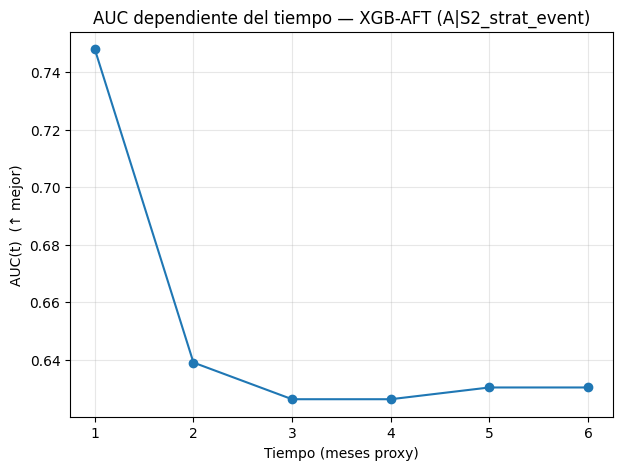

✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/AUC_curve_XGB_A_S2_strat_event.png


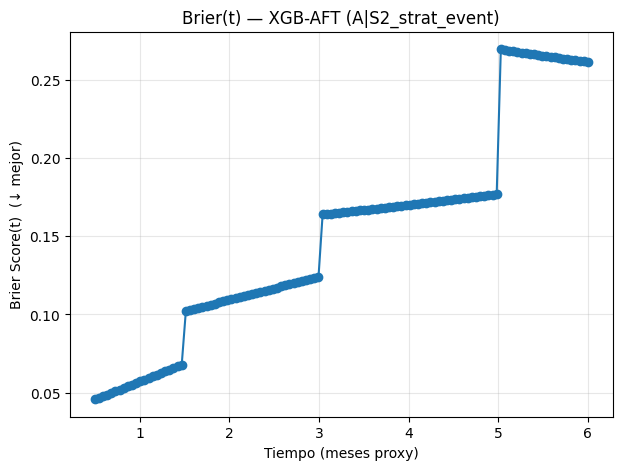

✅ Guardada: /content/artifacts_xgb/refined_best/plots_mvp/Brier_curve_XGB_A_S2_strat_event.png


In [38]:
import os
import pandas as pd
import matplotlib.pyplot as plt

PLOT_DIR = "/content/artifacts_xgb/refined_best/plots_mvp"
best_ds, best_split = "A", "S2_strat_event"

auc_path   = os.path.join(PLOT_DIR, f"auc_t_best_XGB_{best_ds}_{best_split}.csv")
brier_path = os.path.join(PLOT_DIR, f"brier_t_best_XGB_{best_ds}_{best_split}.csv")

# --- AUC(t) ---
df_auc = pd.read_csv(auc_path)   # espera columnas: time, auc (o similar)
plt.figure(figsize=(7,5))
plt.plot(df_auc.iloc[:,0], df_auc.iloc[:,1], marker="o")
plt.xlabel("Tiempo (meses proxy)")
plt.ylabel("AUC(t)  (↑ mejor)")
plt.title(f"AUC dependiente del tiempo — XGB-AFT ({best_ds}|{best_split})")
plt.grid(True, alpha=0.3)
out_auc = os.path.join(PLOT_DIR, f"AUC_curve_XGB_{best_ds}_{best_split}.png")
plt.savefig(out_auc, dpi=160, bbox_inches="tight")
plt.show()
print("✅ Guardada:", out_auc)

# --- Brier(t) ---
df_bs = pd.read_csv(brier_path)  # espera columnas: time, brier (o similar)
plt.figure(figsize=(7,5))
plt.plot(df_bs.iloc[:,0], df_bs.iloc[:,1], marker="o")
plt.xlabel("Tiempo (meses proxy)")
plt.ylabel("Brier Score(t)  (↓ mejor)")
plt.title(f"Brier(t) — XGB-AFT ({best_ds}|{best_split})")
plt.grid(True, alpha=0.3)
out_bs = os.path.join(PLOT_DIR, f"Brier_curve_XGB_{best_ds}_{best_split}.png")
plt.savefig(out_bs, dpi=160, bbox_inches="tight")
plt.show()
print("✅ Guardada:", out_bs)


## Interpretación — AUC dependiente del tiempo \(AUC(t)\)

**Guardada:** `/content/artifacts_xgb/refined_best/plots_mvp/AUC_curve_XGB_A_S2_strat_event.png`

### ¿Qué mide?
En supervivencia, la **AUC dependiente del tiempo** evalúa la capacidad del modelo para **discriminar** (ordenar correctamente) quién tendrá el evento **antes** de un horizonte \(t\).

De forma intuitiva, \(AUC(t)\) es (aprox.) la probabilidad de que, al elegir dos individuos comparables:
- uno que presenta el evento antes de \(t\),
- y otro que sobrevive más allá de \(t\),

el modelo asigne **mayor riesgo** al primero.

\[
AUC(t) \in [0.5, 1], \quad 0.5 \text{ (azar)},\; 1 \text{ (perfecto)}
\]

### ¿Qué se observa en tu curva?
- En tu figura, \(AUC(t)\) es **más alto al inicio** (por ejemplo alrededor del primer mes) y luego **disminuye** y se estabiliza.
- Esto sugiere que el modelo **discrimina mejor inserciones tempranas** (cercanas al inicio del seguimiento) que inserciones hacia el final de la ventana.

### Lectura “con blindaje”
- La caída de \(AUC(t)\) con el tiempo es esperable cuando:
  1) el dataset es pequeño,  
  2) hay censura, y  
  3) hacia \(t\) grandes queda menos población “en riesgo” (menor señal y mayor varianza).
- Por tanto, el modelo parece **más útil para ranking de riesgo temprano** que para separar con alta nitidez eventos tardíos dentro del rango proxy.


## Interpretación — Brier(t) e IBS

**Guardada:** `/content/artifacts_xgb/refined_best/plots_mvp/Brier_curve_XGB_A_S2_strat_event.png`

### ¿Qué mide?
El **Brier Score** en supervivencia mide el **error cuadrático medio** entre lo predicho y lo observado para el estado “sobrevive/no sobrevive” a cada tiempo \(t\).

Usualmente (con ponderación por censura), se interpreta como:
\[
\text{Brier}(t) = \mathbb{E}\left[(\hat{S}(t \mid x) - \mathbb{I}(T>t))^2\right]
\]
donde:
- \(\hat{S}(t \mid x)\) es la supervivencia predicha,
- \(\mathbb{I}(T>t)\) es 1 si el individuo no tuvo el evento antes de \(t\), y 0 caso contrario.

**Menor es mejor.**  
El **IBS (Integrated Brier Score)** resume el desempeño promedio a lo largo del tiempo:
\[
IBS = \int \text{Brier}(t)\, dt \quad (\text{o su aproximación discreta})
\]

### ¿Qué se observa en tu curva?
- Tu \(\text{Brier}(t)\) **crece con el tiempo**, lo cual es normal: conforme \(t\) avanza la predicción es más difícil (menos información efectiva, más censura relativa, menos sujetos en riesgo).
- Se ven **saltos/segmentos**: esto suele ocurrir cuando el conjunto de tiempos evaluados o el “risk set” cambia de forma marcada (por discretización de tiempos proxy, pocos puntos únicos, o cambios fuertes en censura/eventos en determinados cortes).

### Lectura “con blindaje”
- En datasets pequeños, \(\text{Brier}(t)\) puede mostrar escalones o incrementos abruptos porque:
  1) hay pocos tiempos efectivos (proxy discretizado),
  2) la censura a la derecha “concentra” incertidumbre cerca del límite de seguimiento,
  3) hacia \(t\) grandes la estimación se vuelve más inestable.
- Por eso se recomienda reportar **IBS** junto con la curva: IBS actúa como un resumen robusto del error promedio temporal.


In [39]:
import shutil, os

src_dir = "/content/artifacts_xgb"
zip_base = "/content/artifacts_xgb"  # genera /content/artifacts_xgb.zip

zip_path = shutil.make_archive(zip_base, "zip", src_dir)
print("✅ ZIP creado:", zip_path)

# En Colab:
from google.colab import files
files.download(zip_path)


✅ ZIP creado: /content/artifacts_xgb.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>